In [1]:
# if you installed the nico package then uncomment and load the respective modules 

#from nico import Annotations as sann
#from nico import Interactions as sint
#from nico import Covariations as scov

import Annotations as sann
import Interactions as sint
import Covariations as scov

#import scanpy as sc
#import gseapy
#import xlsxwriter

#import numpy as np
#import time
#import os

import matplotlib


In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.linewidth'] = 0.1 #set the value globally

import matplotlib.pyplot as plt
# please use Helvetica font according to your OS to make compatible with Adobe Illustrator. 


#plt.rcParams['font.family'] = 'Helvetica'
#plt.rcParams['font.sans-serif'] = ['Helvetica']
#plt.rcParams['pdf.fonttype'] = 42


In [7]:
# This removes the warning but may not be compatible with Adobe Illustrator 
plt.rc('font', family='sans-serif')

### Usage introduction 
For details of the function usage and input parameters either refer to the documentation or 
just write the function and add .__doc__ to retrieve infromation on all relelvant parameters.

print(sann.find_anchor_cells_between_ref_and_query.__doc__)
print(sint.spatial_neighborhood_analysis.__doc__)
print(scov.gene_covariation_analysis.__doc__)

All the figures will be saved in PDF format as vector graphics by default. 
For every function that generates  figures, the following default parameters are used: 
transparent_mode=False, saveas='pdf',showit=True, dpi=300 

For saving figures in png format, set saveas='png' 
For generating images without background, set transparent_mode=True
If figure outputs within the Jupyter Notebook is not desired, set showit=False

Please download the sample data from the git repository https://github.com/ankitbioinfo/nico_tutorial and keep all the files and folders in the same directory to complete the tutorial. 

inputRef  (single-cell RNA-sequencing data) 
inputQuery (single-cell resolution spatial transcriptomics data)
NiCoLRdb.txt (Ligand-receptor database file) 

Before running the Perform_spatial_analysis.ipynb notebook, input data need to be prepared by running 
the Start_Data_preparation_for_niche_analysis.ipynb notebook
Once all the steps of Start_Data_preparation_for_niche_analysis.ipynb are completed, the following commands can be executed to run a complete NiCo aanlysis. 

In [3]:
ref_datapath='./input_Ref/'
query_datapath='./input_Query/'
output_annotation_dir=None #uses default location  
output_nico_dir=None #uses defautl location 


# Perform cell type annotation of spatial data 

First find anchored cells between two modalities 


In [4]:
anchors_and_neighbors_info=sann.find_anchor_cells_between_ref_and_query(refpath=ref_datapath,quepath=query_datapath,
            output_annotation_dir=output_annotation_dir)


### Selection of parameters 
Perform NiCo cell type annotation using the spatial Leiden cluster from the Start_Data_preparation_for_niche_analysis.ipynb notebook, 
e.g., with Leiden resolution parameter 0.4 
To inspect cell type cluster changes with different parameters, save the "inputQuery/MNN_based_annotations" directory in other locations or delete the directory manually. This function (sann.nico_based_annotation) overwrite the clusters annotation.  

### The annotation slot in scRNAseq data and initial cluster slot in spatial data 
ref_cluster_tag='cluster'
#### ref_cluster_tag define the cellType slot for scRNAseq data. 
Example  .obs['cluster'] 
#### If scRNAseq cellType is stored with some other slot then please change the slot name 

guiding_spatial_cluster_resolution_tag='leiden0.4'
guiding_spatial_cluster_resolution_tag define the clustering slot for spatial data. Example .obs['leiden0.4']


In [5]:
output_info=sann.nico_based_annotation(anchors_and_neighbors_info,
guiding_spatial_cluster_resolution_tag='leiden0.4',
across_spatial_clusters_dispersion_cutoff=0.15,
resolved_tie_issue_with_weighted_nearest_neighbor='No')

This function (sann.delete_files) delete the anchored file details created in the find_anchor_cells_between_ref_and_query step. 
To perform annotations with several different resolution parameters, do not delete this file, since anchor 
information is independent of the resolution parameter. 

In [6]:
#sann.delete_files(output_info)

In [7]:
# Visualize the anchor cells between two modalities. 
# sann.visualize_spatial_anchored_cell_mapped_to_scRNAseq(output_info)

Visualize the spatial annotations of all cell types simultaneously
Left side: tissue map, Right side: UMAP 

The figures are saved:  ./input_Query/MNN_based_annotations/tissue_and_umap_with_all_celltype_annotations.pdf


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


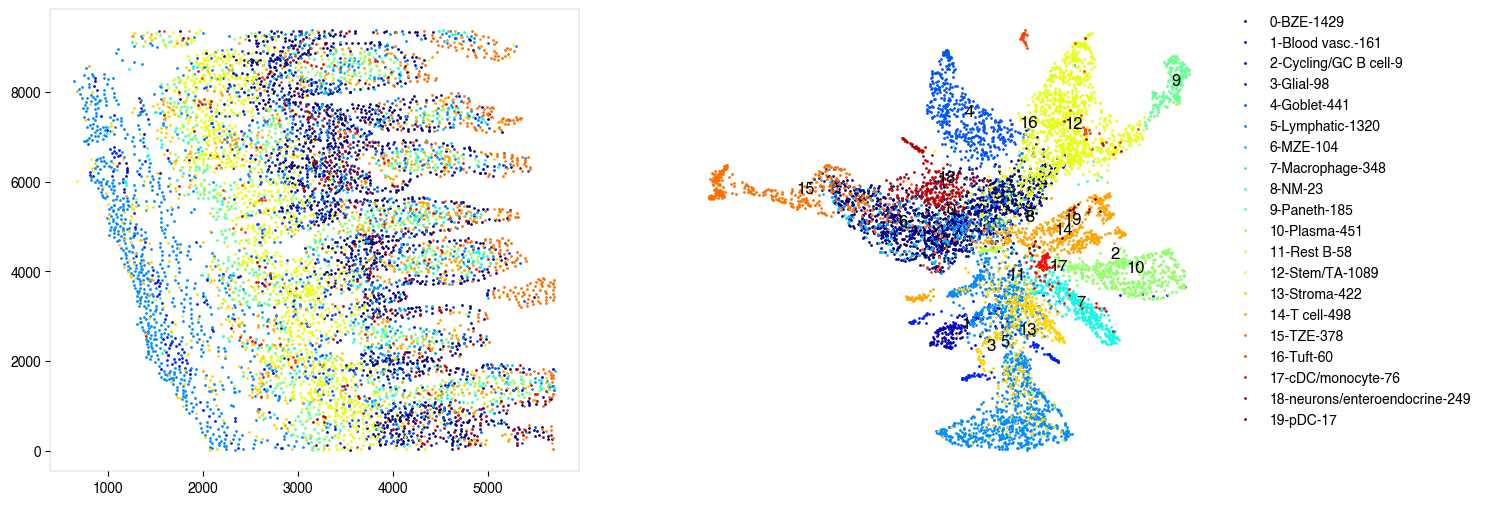

In [6]:
sann.visualize_umap_and_cell_coordinates_with_all_celltypes(saveas='pdf',quepath=query_datapath,
output_annotation_dir=output_annotation_dir)

Visualize  spatial annotations of selected pairs (or larger sets) of cell types  
Left side: tissue map, Right side: UMAP 

The figures are saved:  ./input_Query/MNN_based_annotations/fig_individual_annotation/Stem_TA0.pdf
The figures are saved:  ./input_Query/MNN_based_annotations/fig_individual_annotation/Paneth1.pdf


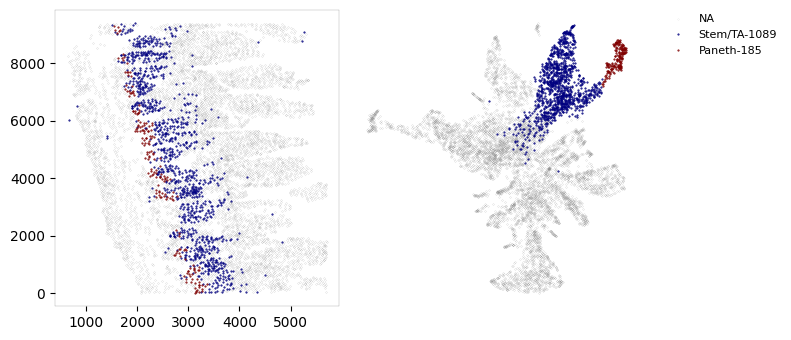

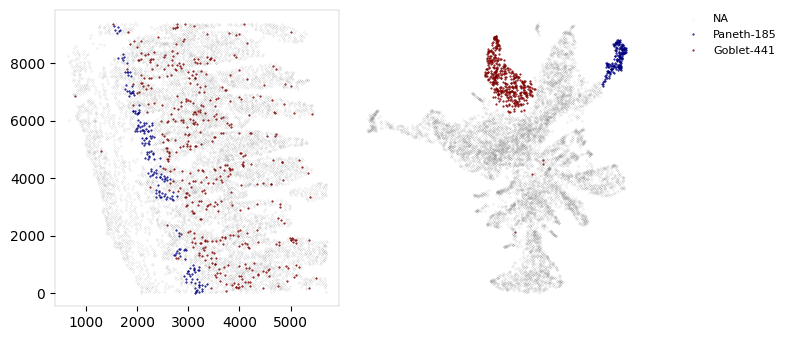

In [8]:
choose_celltypes=[['Stem/TA','Paneth'],['Paneth','Goblet']]
sann.visualize_umap_and_cell_coordinates_with_selected_celltypes(choose_celltypes=choose_celltypes,
                        quepath=query_datapath,
                        saveas='pdf',output_annotation_dir=output_annotation_dir)

In [9]:
# For visualizing every cell type individually, leave list choose_celltypes list empty.  
#sann.visualize_umap_and_cell_coordinates_with_selected_celltypes(choose_celltypes=[])

In [10]:
#SAVE the annotation file into h5ad object along with expression matrix in current directory 
sann.save_annotations_in_spatial_object(output_info,output_h5ad_name='spatial_intestine_with_nico_annotations')

Nico based cluster annotations are saved in .obs['nico_ct'] slot


# Infer significant niche cell type interactions 

### If annotations files are already have it from other program  
If user modify the annotation or use annotations from some other algorithm then the new annotations can be given as follows: 
clusterFilename= path of 2 column csv file with header info included 
(first column:cell barcode, second column: integer cluster id) 
celltypeFilename=path of 2 column csv file with header info included 
(first column:integer cluster id, second column: cell type name) 

### Radius definition 
Perform  neighborhood analysis across direct neighbors (juxtacrine signaling, R=0) of the central niche cell type.   
To exclude cell types from the neighborhood analysis, add celltype names to the list removed_CTs_before_finding_CT_CT_interactions.
In the example below, the cell types NM, Basophils, Cycling/GC B cell, and pDC, would not be included. 

In [11]:
# By default it take the annotations file from the previous annotations steps 
clusterFilename=None
celltypeFilename=None

In [12]:
niche_pred_output=sint.spatial_neighborhood_analysis(Radius=0,
clusterFilename=clusterFilename,
quepath=query_datapath, 
celltypeFilename=celltypeFilename,
output_annotation_dir=output_annotation_dir,
output_niche_prediction_dir=output_nico_dir,
removed_CTs_before_finding_CT_CT_interactions=['Basophils','Cycling/GC B cell','pDC'])

average neighbors: 4.844577168453916
average distance: 85.28447652743172
data shape (7338, 19) (7338,) neighbor shape (7338, 17)
Searching hyperparameters  Grid method: 0.00390625
Searching hyperparameters  Grid method: 0.00390625
Inverse of lambda regularization found 0.00390625
training (5871, 17) testing (1467, 17) coeff (17, 17)


Order niche cell types by magnitude of regression coefficients, add celltype names to the list argument 
choose_celltypes, e.g., for the Stem/TA and Paneth cell niche. 

The figures are saved:  ./spatial_ct_ct_interactions/niche_prediction_linear/TopCoeff_R0/Rank1_Paneth.pdf
The figures are saved:  ./spatial_ct_ct_interactions/niche_prediction_linear/TopCoeff_R0/Rank3_Stem_TA.pdf


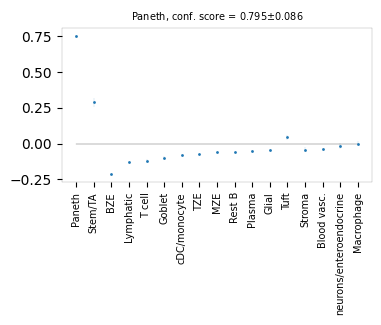

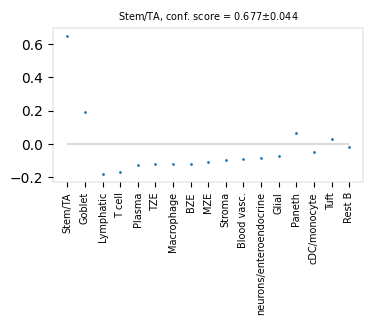

In [13]:
sint.find_interacting_cell_types(niche_pred_output,choose_celltypes=['Stem/TA','Paneth'],
saveas='pdf')

If niche cell types from the niche neighborhood of all central cell types should be plotted or saved, 
then leave choose_celltypes list argument empty. 

In [14]:
#sint.find_interacting_cell_types(niche_pred_output,choose_celltypes=[])

In [15]:
# Plot the ROC curve of the classifier prediction for one of the crossfolds. 
# sint.plot_roc_results(niche_pred_output)

Plot the average confusion matrix of the classifier from cross-folds 

The figures are saved:  ./spatial_ct_ct_interactions/niche_prediction_linear/Confusing_matrix_R0.pdf


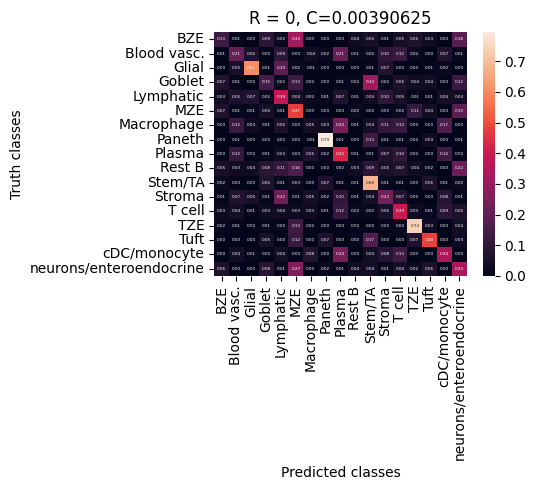

In [16]:
sint.plot_confusion_matrix(niche_pred_output,saveas='pdf')

Plot the average coefficient matrix of the classifier from cross-folds 

The figures are saved:  ./spatial_ct_ct_interactions/niche_prediction_linear/weight_matrix_R0.pdf


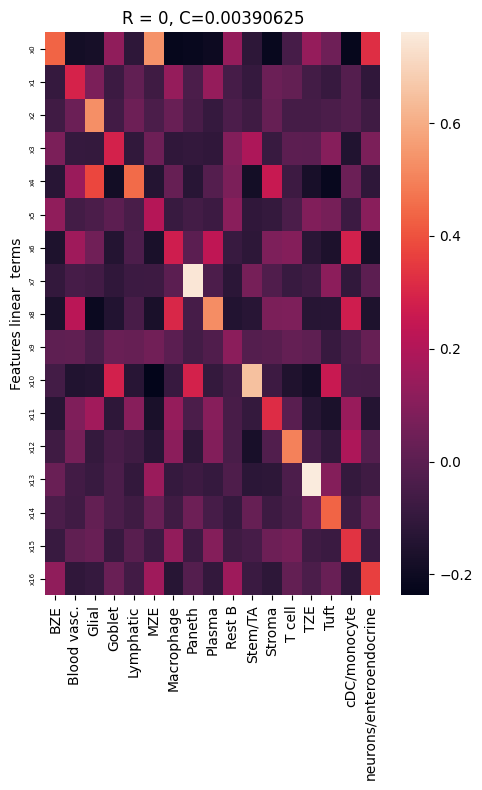

In [17]:
sint.plot_coefficient_matrix(niche_pred_output,saveas='pdf')

Plot the evaluation score of the classifier for different metrics 

The figures are saved:  ./spatial_ct_ct_interactions/niche_prediction_linear/scores_0.pdf


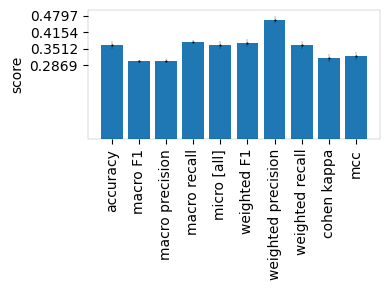

In [18]:
sint.plot_evaluation_scores(niche_pred_output, figsize=(4,3),saveas='pdf')

In some computing machine pygraphviz not able to load the neato package automatically. 
In such case please define the location of the neato package.  

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


The figures are saved:  ./spatial_ct_ct_interactions/niche_prediction_linear/Niche_interactions_without_edge_weights_R0.pdf


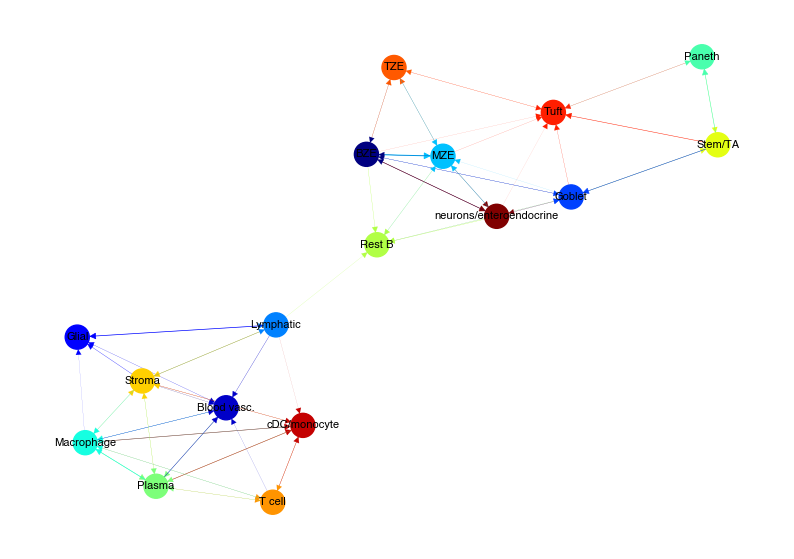

In [19]:
# Plot the niche interaction network without any edge weight details for cutoff 0.04 
sint.plot_niche_interactions_without_edge_weight(niche_pred_output,niche_cutoff=0.04, saveas='pdf')

The figures are saved:  ./spatial_ct_ct_interactions/niche_prediction_linear/Niche_interactions_with_edge_weights_R0.pdf


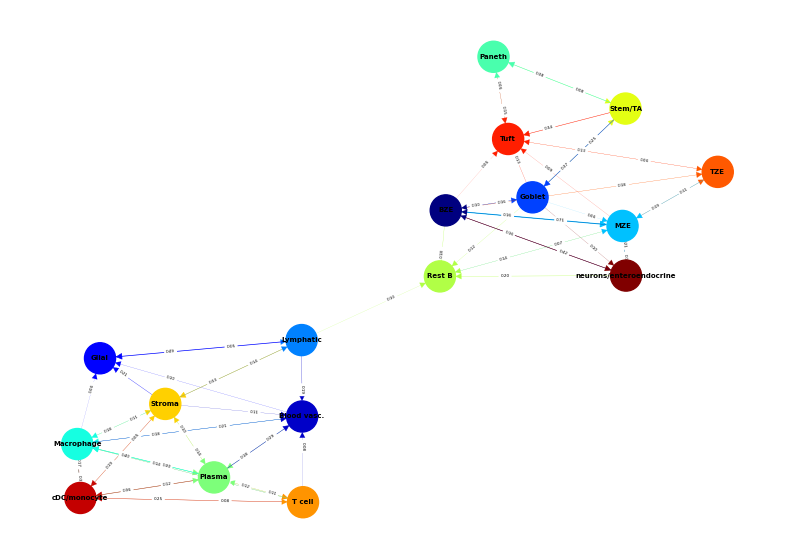

In [20]:
# Plot the niche interaction network with edge weight details for cutoff 0.05
sint.plot_niche_interactions_with_edge_weight(niche_pred_output,niche_cutoff=0.05,saveas='pdf')

# Perform niche cell state covariation analysis using latent factors

### Covariations parameters settings 
Infer desired number of latent factors (e.g., no_of_factors=3) for each cell type from both modalities using 
integrated non-negative matrix factorization. 
Set iNMFmode=False for appling the conventional non-negative matrix factorization method. In this case, latent factors 
will be derived from the scRNA-seq data and transfered to the spatial modality. 
This option is preferable if spatial data are affected by substantial technical noise due to unspecific background signal
or gene expression spill-over between neighboring cell types due to imperfect segmentation.

### The annotations slot in scRNAseq data 
ref_cluster_tag='cluster'
ref_cluster_tag define the location slot for example .obs['cluster']
in this slot cell type annotation of scRNAseq data is stored 

### Ligand-Receptor database file 
NiCoLRdb.txt is the name of the ligand-receptor database file. Users can use databases of similar format from any resource. 
NiCoLRdb.txt was created by merging ligand-receptor pairs from NATMI, OMNIPATH, and CellPhoneDB. 
User can download this database from github and put into local directory from where this notebook is getting run. 

In [21]:
all_output_data=scov.gene_covariation_analysis(iNMFmode=True,
        Radius=0,
        no_of_factors=3,
        refpath=ref_datapath,
        quepath=query_datapath,
        output_niche_prediction_dir=output_nico_dir,
        ref_cluster_tag='cluster') #LRdbFilename='NiCoLRdb.txt'

common genes between sc and sp 203 203


 Spatial and scRNA-seq number of clusters, respectively  17 19
Common cell types between spatial and scRNA-seq data   17 {'Glial', 'Paneth', 'T cell', 'cDC/monocyte', 'Blood vasc.', 'Lymphatic', 'MZE', 'Goblet', 'TZE', 'neurons/enteroendocrine', 'Stroma', 'Stem/TA', 'Plasma', 'Tuft', 'BZE', 'Macrophage', 'Rest B'}

The spatial cluster name does not match the scRNA-seq cluster name  set()
If the above answer is Null, then everything is okay. However, if any spatial cell type does not exist in the scRNA-seq data, please correct this manually; otherwise, NiCo will not run. 





Visualize the cosine similarity and Spearman correlation between genes and latent factors 
Following function generates output for the top 30 genes based on cosine similarity (left) or Spearman correlation (right) 

Select cell types by adding IDs to list argument choose_celltypes, or leave empty for generating output for all cell types

cell types found  ['Paneth']
The figures are saved:  ./spatial_ct_ct_interactions/covariations_R0_F3/NMF_output/Paneth.pdf


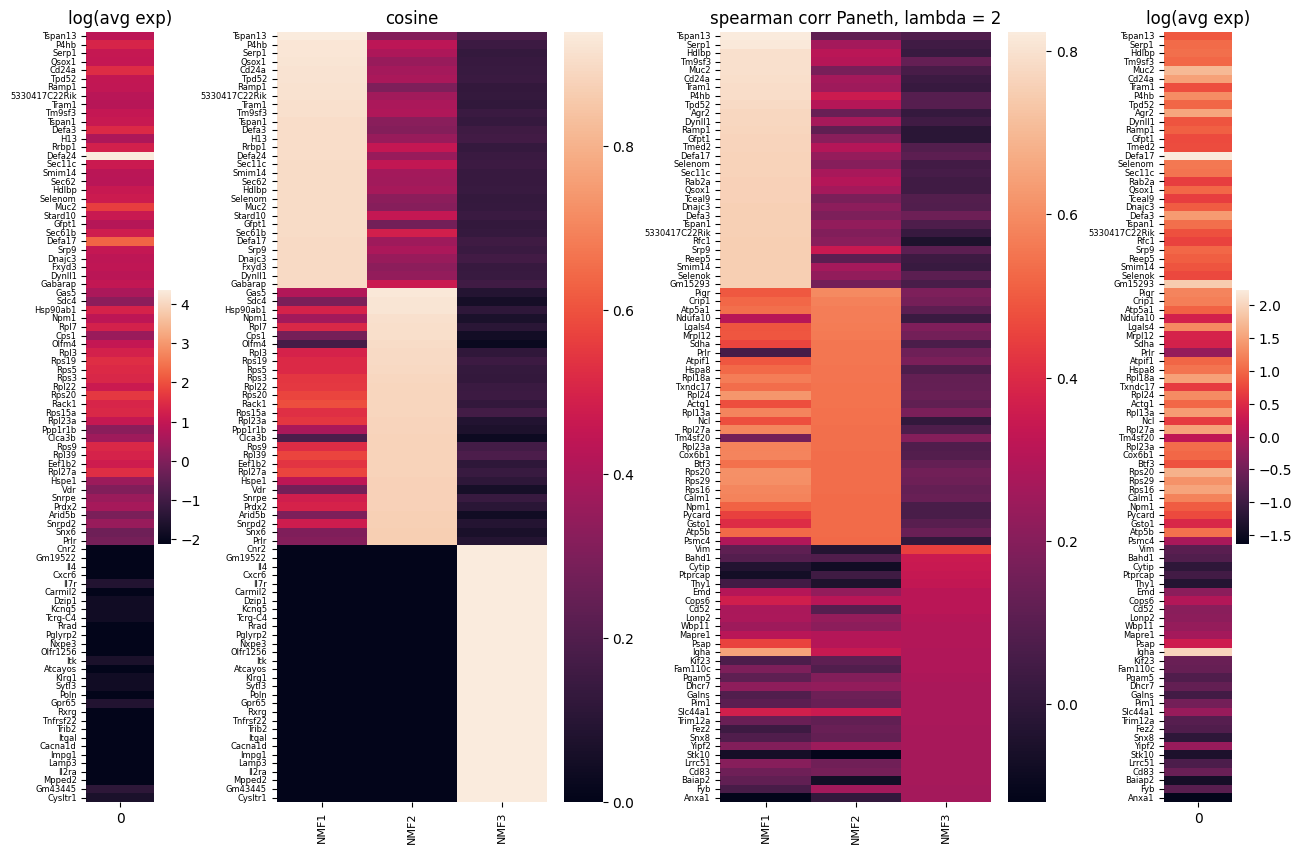

In [22]:
scov.plot_cosine_and_spearman_correlation_to_factors(all_output_data,choose_celltypes=['Paneth'],
                    NOG_Fa=30,saveas='pdf')

cell types found  ['Stem/TA']
The figures are saved:  ./spatial_ct_ct_interactions/covariations_R0_F3/NMF_output/Stem_TA.pdf


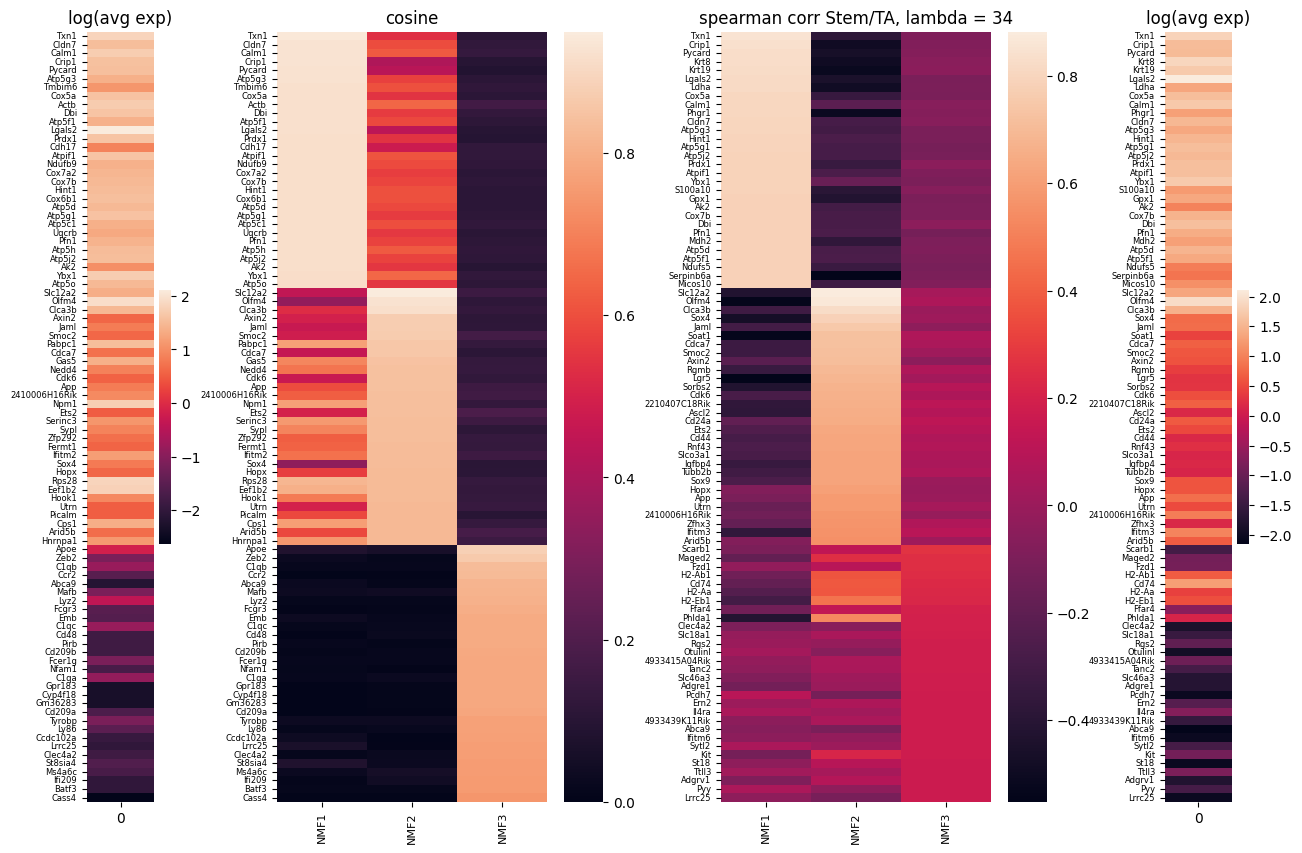

In [23]:
scov.plot_cosine_and_spearman_correlation_to_factors(all_output_data,choose_celltypes=['Stem/TA'],
                    NOG_Fa=30,saveas='pdf')

### Visualize genes in the latent factors along with average expression 
Call following function (scov.extract_and_plot_top_genes_from_chosen_factor_in_celltype) to visualize correlation 
and expression of genes associated with factors

For example, visualize and extract the top 10 genes (top_NOG=10)
correlating negatively (positively_correlated=False)
by Spearman correlation (correlation_with_spearman=True)
for cell type Stem/TA (choose_celltype='Stem/TA')
in factor 1 (choose_factor_id=1)


The figures are saved:  ./spatial_ct_ct_interactions/covariations_R0_F3/dotplots/Factors_Stem_TA.pdf


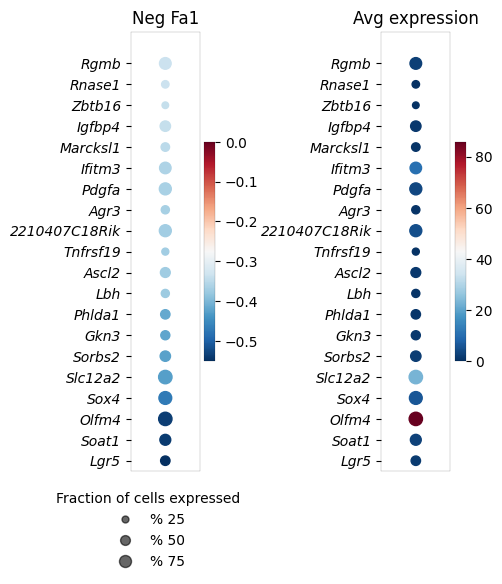

In [24]:
dataFrame=scov.extract_and_plot_top_genes_from_chosen_factor_in_celltype(all_output_data,choose_celltype='Stem/TA',
choose_factor_id=1,top_NOG=20,correlation_with_spearman=True,positively_correlated=False)

### Visualize the latent factor values and proportion of population expressed that gene 
inspect the top genes in the given factor as in table
proportion_of_population_expressed: proportion of cells expressing a gene in the respective cluster 


In [25]:
dataFrame

Gene        Fa  mean_expression  \
0            Lgr5 -0.551579         1.985714   
1           Soat1 -0.540120         2.752381   
2           Olfm4 -0.538151        85.804764   
3            Sox4 -0.469720         6.140476   
4         Slc12a2 -0.427825        22.964285   
5          Sorbs2 -0.426492         2.016667   
6            Gkn3 -0.420468         1.452381   
7          Phlda1 -0.416347         1.309524   
8             Lbh -0.376701         0.680952   
9           Ascl2 -0.373048         1.516667   
10       Tnfrsf19 -0.371906         0.402381   
11  2210407C18Rik -0.370768         4.821429   
12           Agr3 -0.367172         0.673810   
13          Pdgfa -0.364915         3.902381   
14         Ifitm3 -0.361266        10.678572   
15       Marcksl1 -0.349501         0.733333   
16         Igfbp4 -0.342489         1.480952   
17         Zbtb16 -0.342387         0.423810   
18         Rnase1 -0.335670         0.509524   
19           Rgmb -0.334278         2.495238   

    proportion_of_population_expressed  
0                             0.459524  
1                             0.611905  
2                             0.921429  
3                             0.847619  
4                             0.930952  
5                             0.554762  
6                             0.423810  
7                             0.452381  
8                             0.338095  
9                             0.500000  
10                            0.252381  
11                            0.740476  
12                            0.342857  
13                            0.740476  
14                            0.683333  
15                            0.371429  
16                            0.559524  
17                            0.223810  
18                            0.285714  
19                            0.702381

### Save the latent factors into excel sheet 
save data in an Excel sheet for each cell type, including latent factor associations of all genes according to 
Spearman correlation and cosine similarity. 

In [26]:
scov.make_excel_sheet_for_gene_correlation(all_output_data)

### Visualization setting  
Plot covariations between niche cell types (x-axis) and central cell type (y-axis, defined by list argument choose_celltypes). 
Circle size scales with -log10 p-value (indicated as number on top of each circle). 
To generate plots for all cell types, leave list argument choose_celltypes empty. 

cell types found  ['Stem/TA']
The regression figures as pvalue circle plots are saved in following path  ./spatial_ct_ct_interactions/covariations_R0_F3/Regression_outputs/pvalue_coeff_circleplot_*


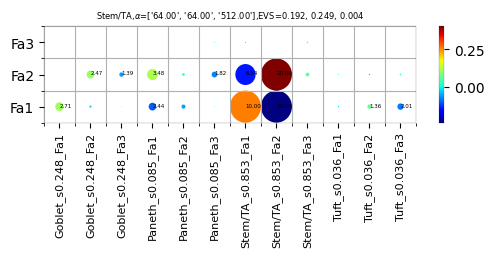

In [27]:
choose_celltypes=['Stem/TA']
scov.plot_significant_regression_covariations_as_circleplot(all_output_data,
    choose_celltypes=choose_celltypes, saveas='pdf')


In the following example, a p-value cutoff is explicitely defined by the pvalue_cutoff argument.

cell types found  ['Stem/TA']
The regression figures as pvalue circle plots are saved in following path  ./spatial_ct_ct_interactions/covariations_R0_F3/Regression_outputs/pvalue_coeff_circleplot_*


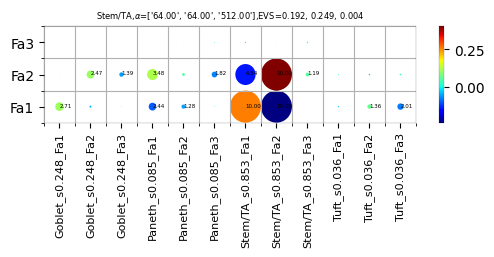

In [28]:
choose_celltypes=['Stem/TA']
scov.plot_significant_regression_covariations_as_circleplot(all_output_data,
            choose_celltypes=choose_celltypes,pvalue_cutoff=0.1,mention_pvalue=True)


In the following example, the -log10 p-value is not printed on top of circles.

cell types found  ['Stem/TA']
The regression figures as pvalue circle plots are saved in following path  ./spatial_ct_ct_interactions/covariations_R0_F3/Regression_outputs/pvalue_coeff_circleplot_*


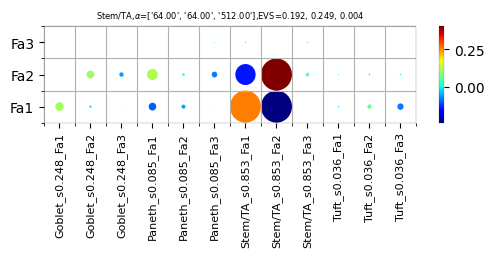

In [29]:
choose_celltypes=['Stem/TA']
scov.plot_significant_regression_covariations_as_circleplot(all_output_data,
            choose_celltypes=choose_celltypes,pvalue_cutoff=0.05,mention_pvalue=False,saveas='pdf')

### Visualize as heatmap instead of circle plot 
Plot covariations between niche cell types (x-axis) and central cell type (y-axis, defined by list argument choose_celltypes) as heatmap.
Leave list argument choose_celltypes empty to generate plots for all cell types.
The top subfigure shows the coefficient and bottom subfigure shows the -log10 p-value. 

cell types found  ['Stem/TA']
The regression figures as pvalue heatmap plots are saved in following path  ./spatial_ct_ct_interactions/covariations_R0_F3/Regression_outputs/pvalue_coeff_heatmap_*


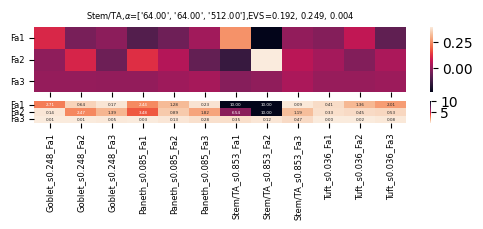

In [30]:
scov.plot_significant_regression_covariations_as_heatmap(all_output_data,
    choose_celltypes=['Stem/TA'],transparent_mode='False',figsize=(6,1.25))


### Save excelsheets and summary in text file    
Save all ligand-receptor interactions infered for the niche of each cell type niche in an Excel sheet,  
and a summary of significant niche interactions in a text file. 


In [31]:
scov.save_LR_interactions_in_excelsheet_and_regression_summary_in_textfile_for_interacting_cell_types(all_output_data,
pvalueCutoff=0.05,correlation_with_spearman=True,
LR_plot_NMF_Fa_thres=0.2,LR_plot_Exp_thres=0.2,number_of_top_genes_to_print=5)


The Excel sheet is saved:  ./spatial_ct_ct_interactions/covariations_R0_F3/Lig_and_Rec_enrichment_in_interacting_celltypes.xlsx
The text file is saved: ./spatial_ct_ct_interactions/covariations_R0_F3/Regression_summary.txt


# Generate visualizations of ligand-receptor interactions within the niche

### Usage for ligand receptor visualizations 
Perform ligand-receptors analysis
In this example, output is generated for the ligand-receptor pairs associated with the intercting 
factor 1 of Stem/TA cells and factor 1 of Paneth cells. 

choose_interacting_celltype_pair=['Stem/TA','Paneth'] 
choose_factors_id=[1,1] entries correspond to cell types in choose_interacting_celltype_pai, i.e., 
first factor ID corresponds to Stem/TA and second factor ID corresponds to Paneth

By default, the analysis is saved in 3 separate figures (bidirectional, CC to NC and NC to CC). 
CC: central cell 
NC: niche cell 

Our analysis accounts for bidirectional cellular crosstalk interactions of ligands and receptors in cell types A and B.
The ligand can be expressed on cell type A and signal to the receptor detected on cell type B, or vice versa.

By changing the cutoff for minimum factor correlation of ligand/receptor genes (LR_plot_NMF_Fa_thres=0.2) 
or the cutoff for the minimum fraction of cells expressing the ligand/receptor genes (LR_plot_Exp_thres=0.2) the 
stringency of the output filtering can be controled. 



LR figures for both ways are saved in following path  ./spatial_ct_ct_interactions/covariations_R0_F3/Plot_ligand_receptor_in_niche/
LR figures for CC to NC are saved in following path  ./spatial_ct_ct_interactions/covariations_R0_F3/Plot_ligand_receptor_in_niche_cc_vs_nc/
LR figures for NC to CC are saved in following path  ./spatial_ct_ct_interactions/covariations_R0_F3/Plot_ligand_receptor_in_niche_nc_vs_cc/


0

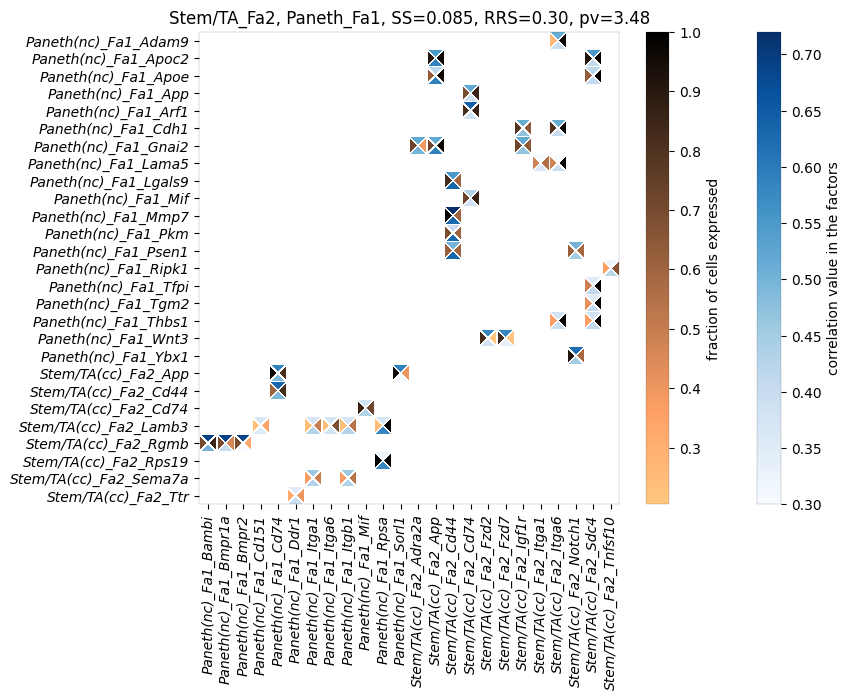

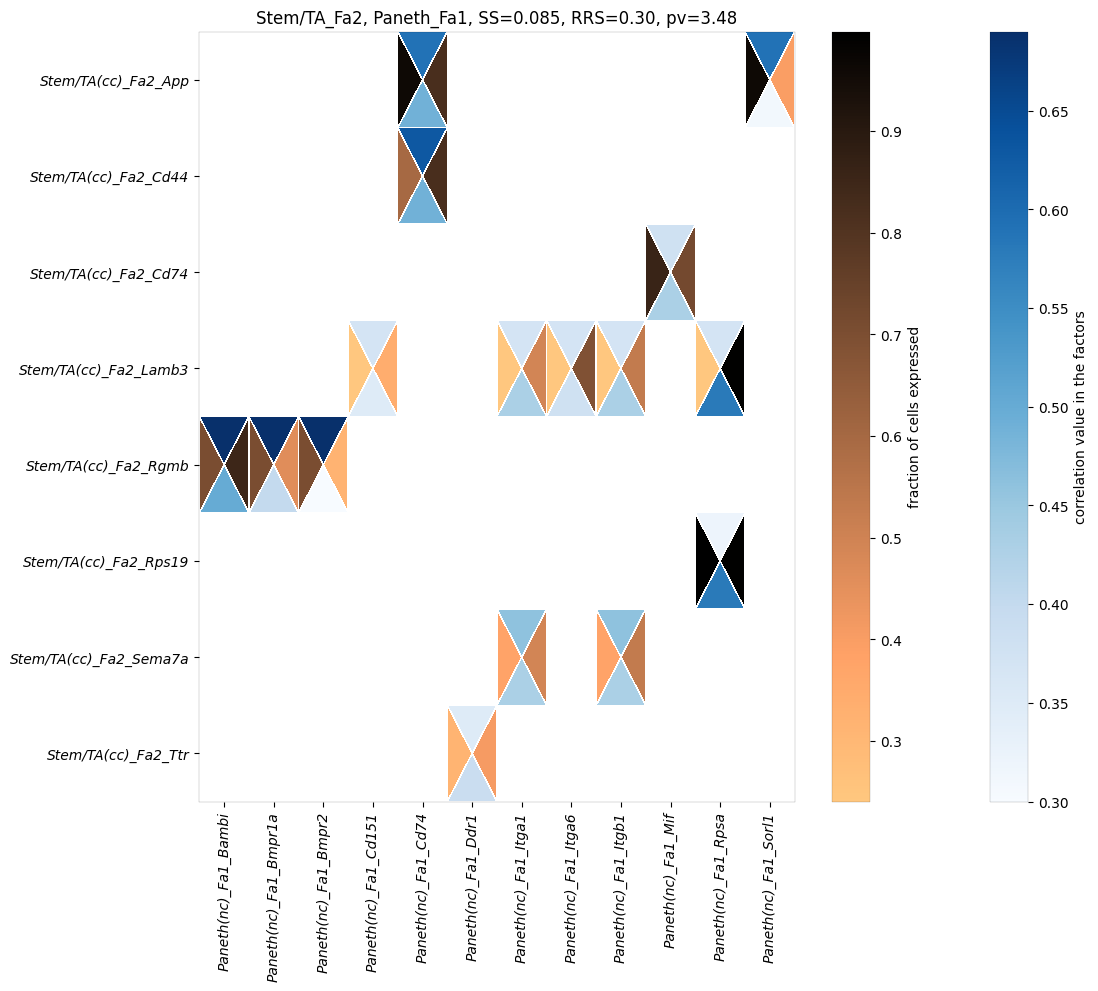

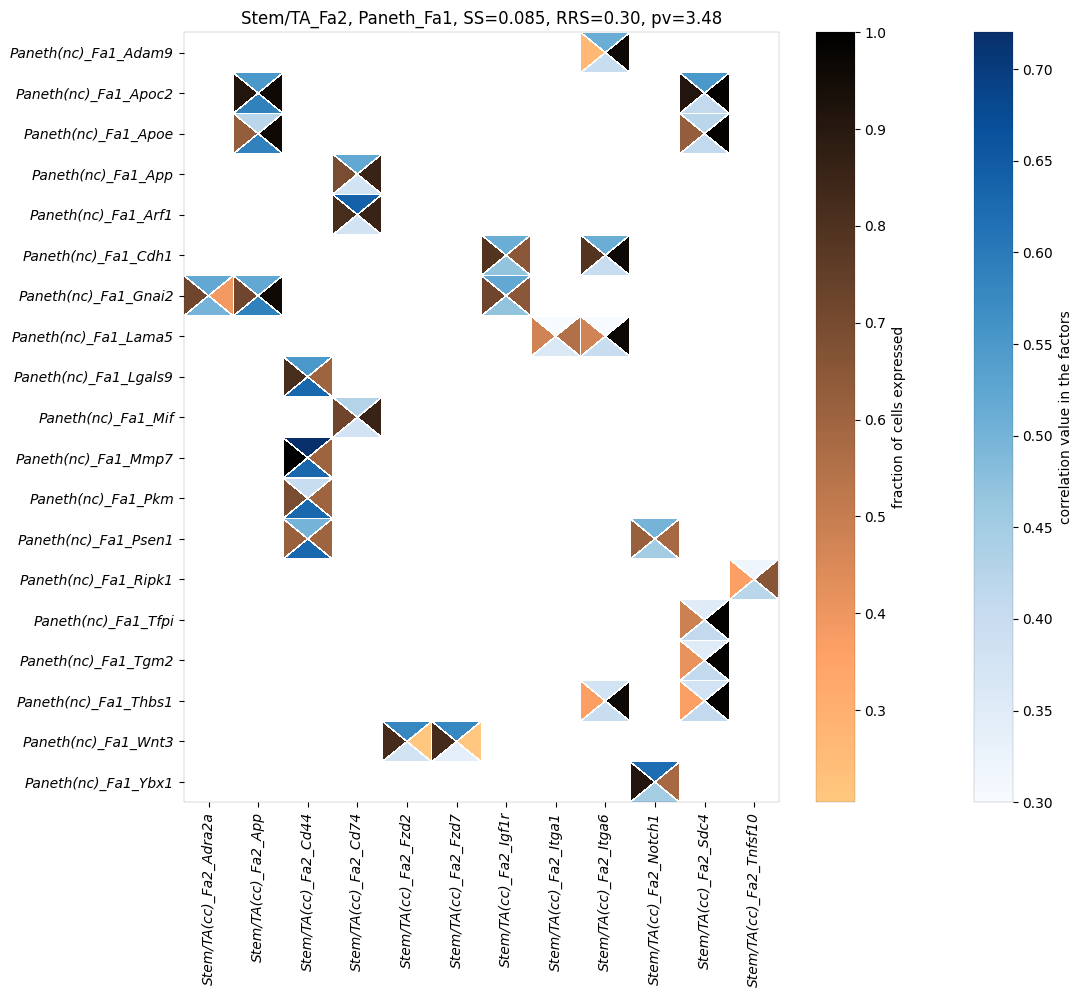

In [32]:
scov.find_LR_interactions_in_interacting_cell_types(all_output_data,
choose_interacting_celltype_pair=['Stem/TA','Paneth'],saveas='pdf',choose_factors_id=[2,1],pvalueCutoff=0.05,
    LR_plot_NMF_Fa_thres=0.3,LR_plot_Exp_thres=0.2)

Perform ligand-receptors analysis of the Paneth cell niche including all significant interaction partners. 
choose_interacting_celltype_pair=['Paneth']   generate plots for all cell types interacting sigificantly with Paneth cells 
choose_factors_id=[]  if empty, generate plots for all significantly covarying factors


In [33]:
#scov.find_LR_interactions_in_interacting_cell_types(all_output_data,choose_interacting_celltype_pair=['Paneth'],
 #   choose_factors_id=[], saveas='png',LR_plot_NMF_Fa_thres=0.2,LR_plot_Exp_thres=0.2)


# Perform functional enrichment analysis for genes associated with latent factors 

### Perform pathway enrichment analysis for factor-associated genes

In this example, pathway analysis is performed for top 50 (NOG_pathway=50) genes, 

positively correlated (positively_correlated=True) with 

factor 1 (choose_factors_id=[2]) of Stem/TA cells (choose_celltypes=['Stem/TA'])

testing for enrichment of GO Biological Processes (database=['GO_Biological_Process_2021']).

If savefigure=True, then the figures will be saved in the respective folder. 

The pathway figures are saved in  ./spatial_ct_ct_interactions/covariations_R0_F3/Pathway_figures/
cell types found  ['Stem/TA']


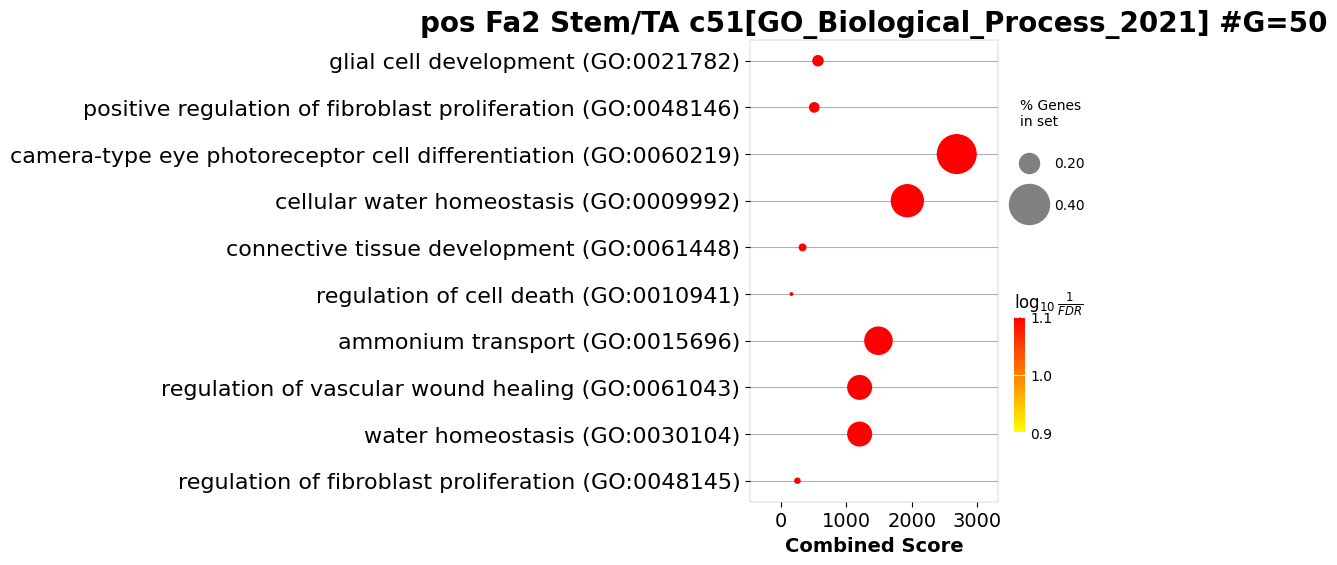

In [34]:
scov.pathway_analysis(all_output_data,choose_celltypes=['Stem/TA'],
NOG_pathway=50,choose_factors_id=[2],
positively_correlated=True,savefigure=False,database=['GO_Biological_Process_2021'])

In this example, pathway analysis is performed for top 50 (NOG_pathway=50) genes, 
negatively correlated (positively_correlated=False) 
with factor 1 (choose_factors_id=[2])
of Stem/TA cells (choose_celltypes=['Stem/TA'])
testing for enrichment of GO Biological Processes (database=['GO_Biological_Process_2021']).

If savefigure=True, then the figures will be saved in the respective folder. 


The pathway figures are saved in  ./spatial_ct_ct_interactions/covariations_R0_F3/Pathway_figures/
cell types found  ['Stem/TA']


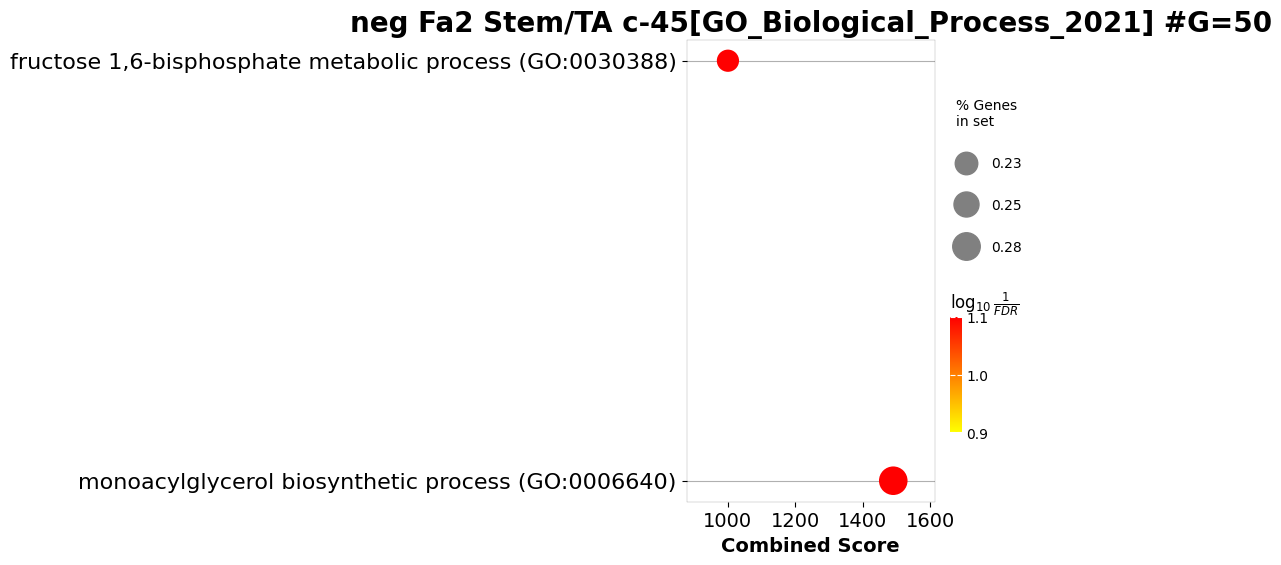

In [35]:
scov.pathway_analysis(all_output_data,choose_celltypes=['Stem/TA'],
NOG_pathway=50,choose_factors_id=[2],
positively_correlated=False,savefigure=False,database=['GO_Biological_Process_2021'])

In this example, pathway analyses are performed for top 50 (NOG_pathway=50) genes, 
positively correlated (positively_correlated=True) 
with any factor (choose_factors_id=[])
of Paneth cells (choose_celltypes=['Paneth'])
ribosome and mitochondrial genes are not included in the gene list 
testing for enrichment of pathways from three databases (GO_Biological_Process_2021','BioPlanet_2019','Reactome_2016').


The pathway figures are saved in  ./spatial_ct_ct_interactions/covariations_R0_F3/Pathway_figures/
cell types found  ['Paneth']


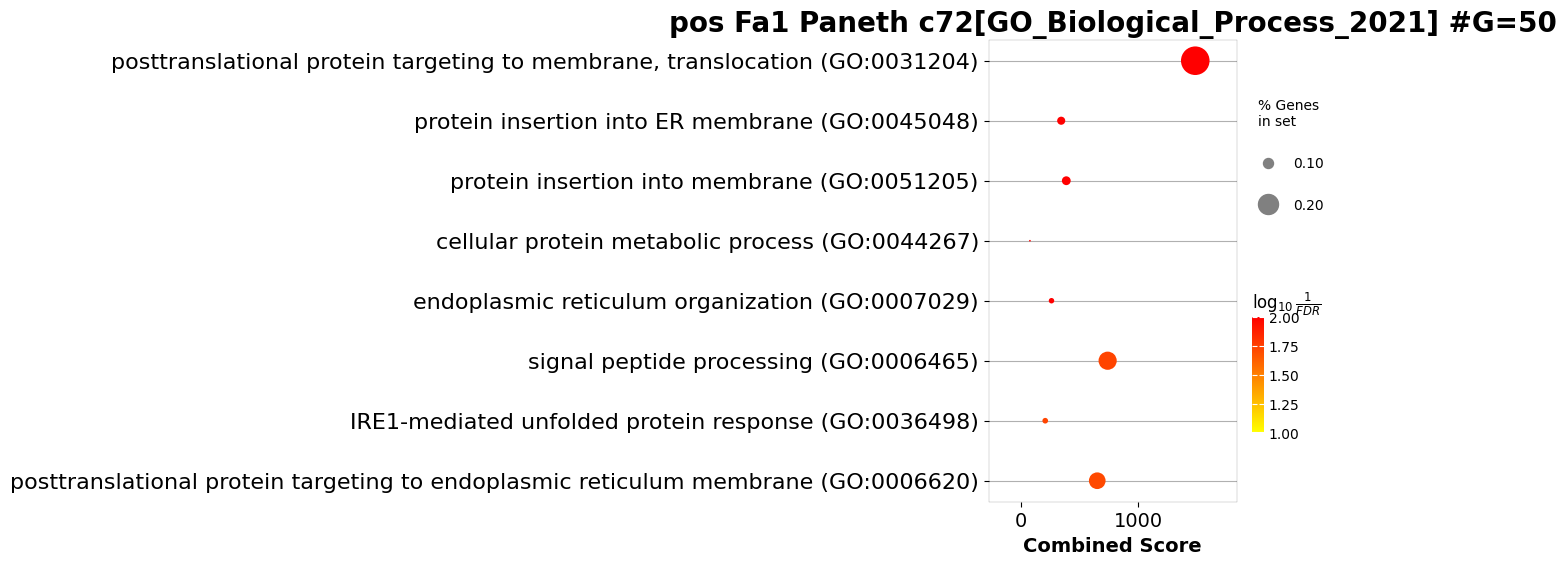

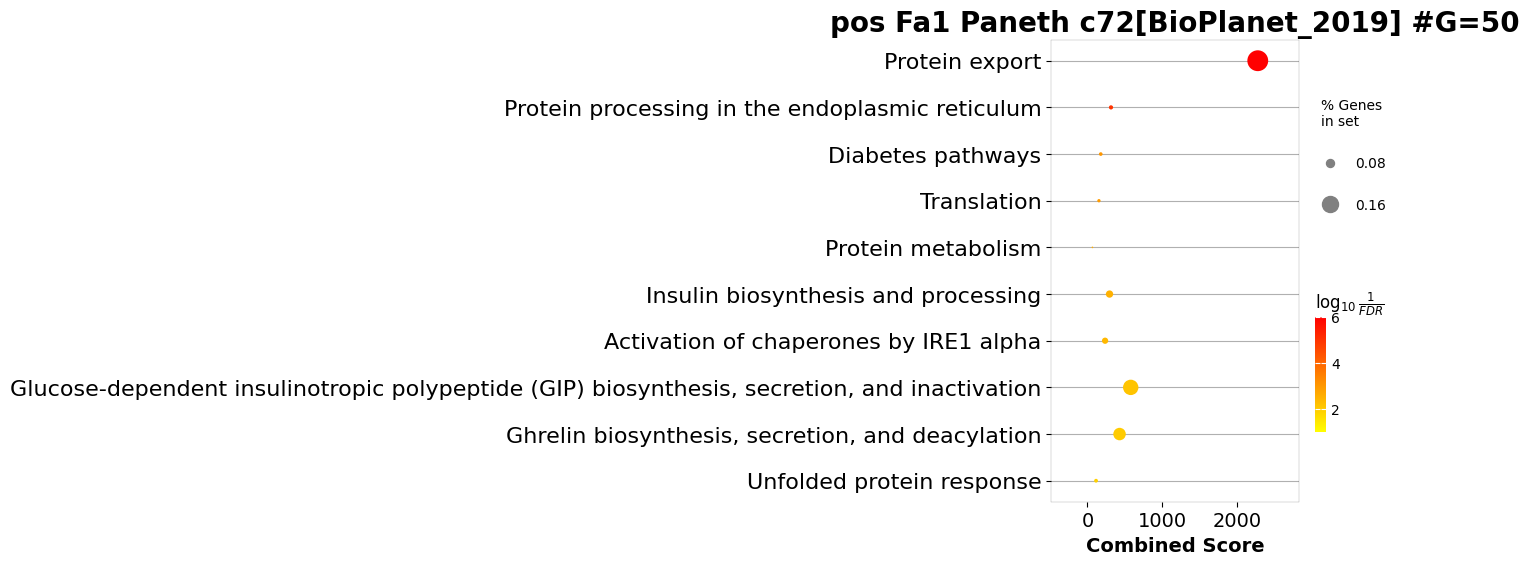

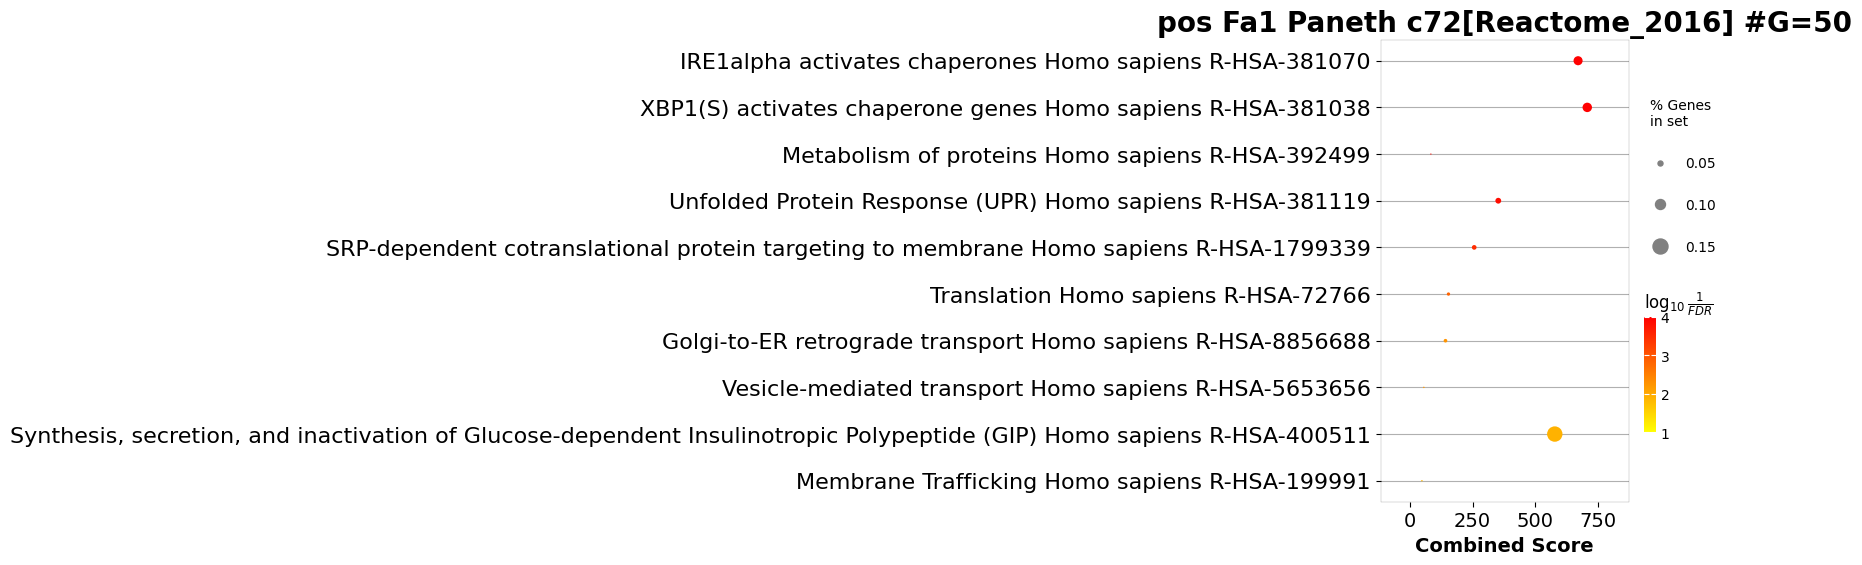

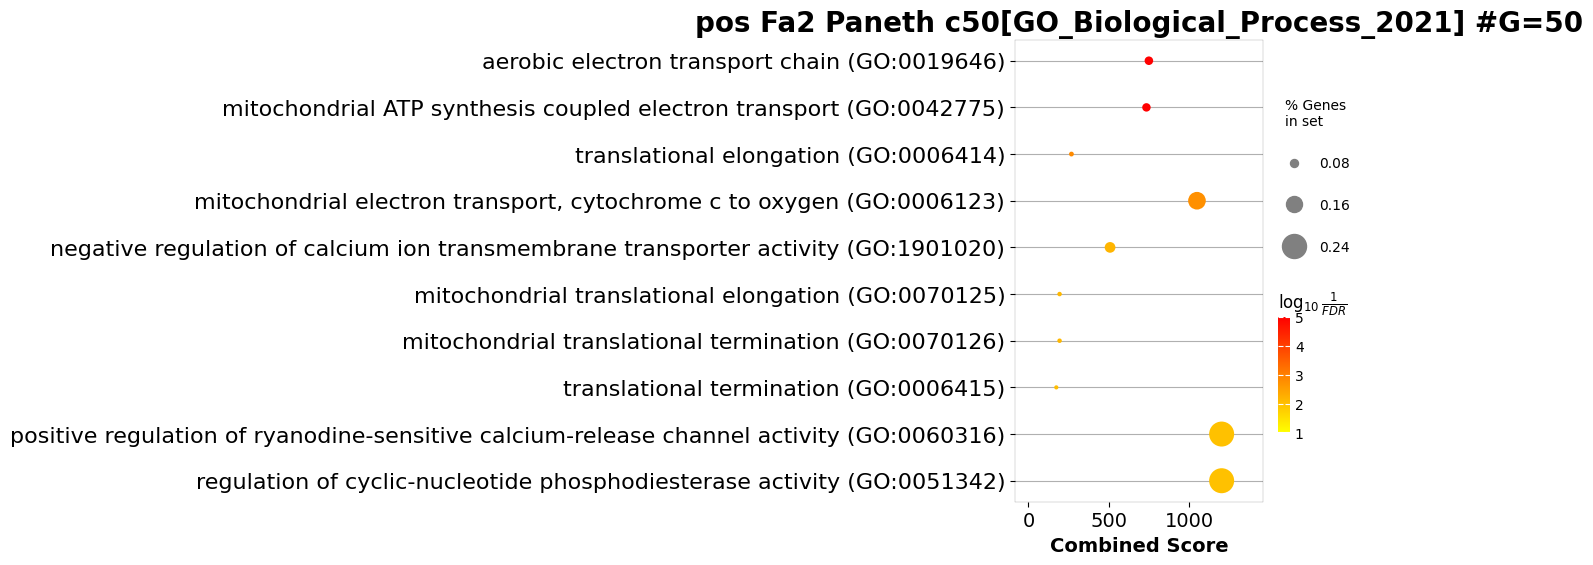

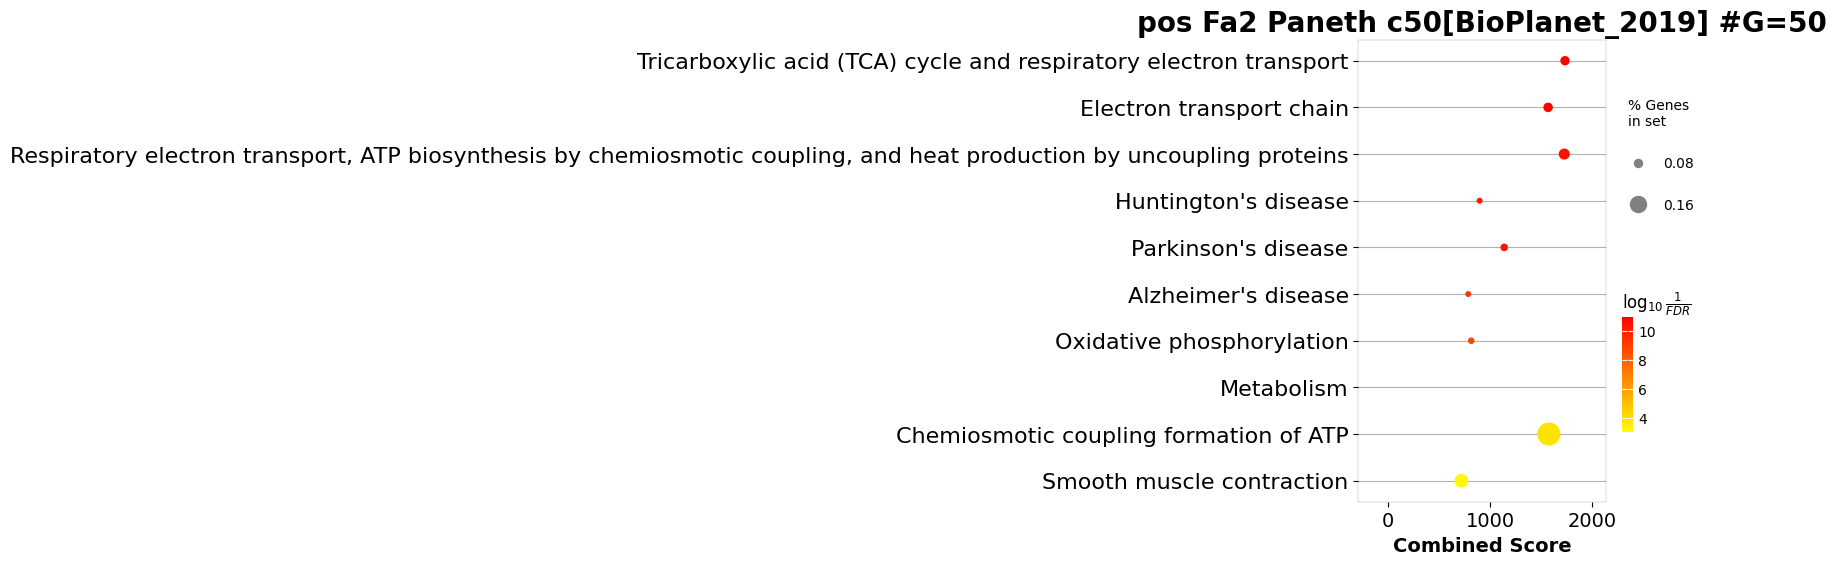

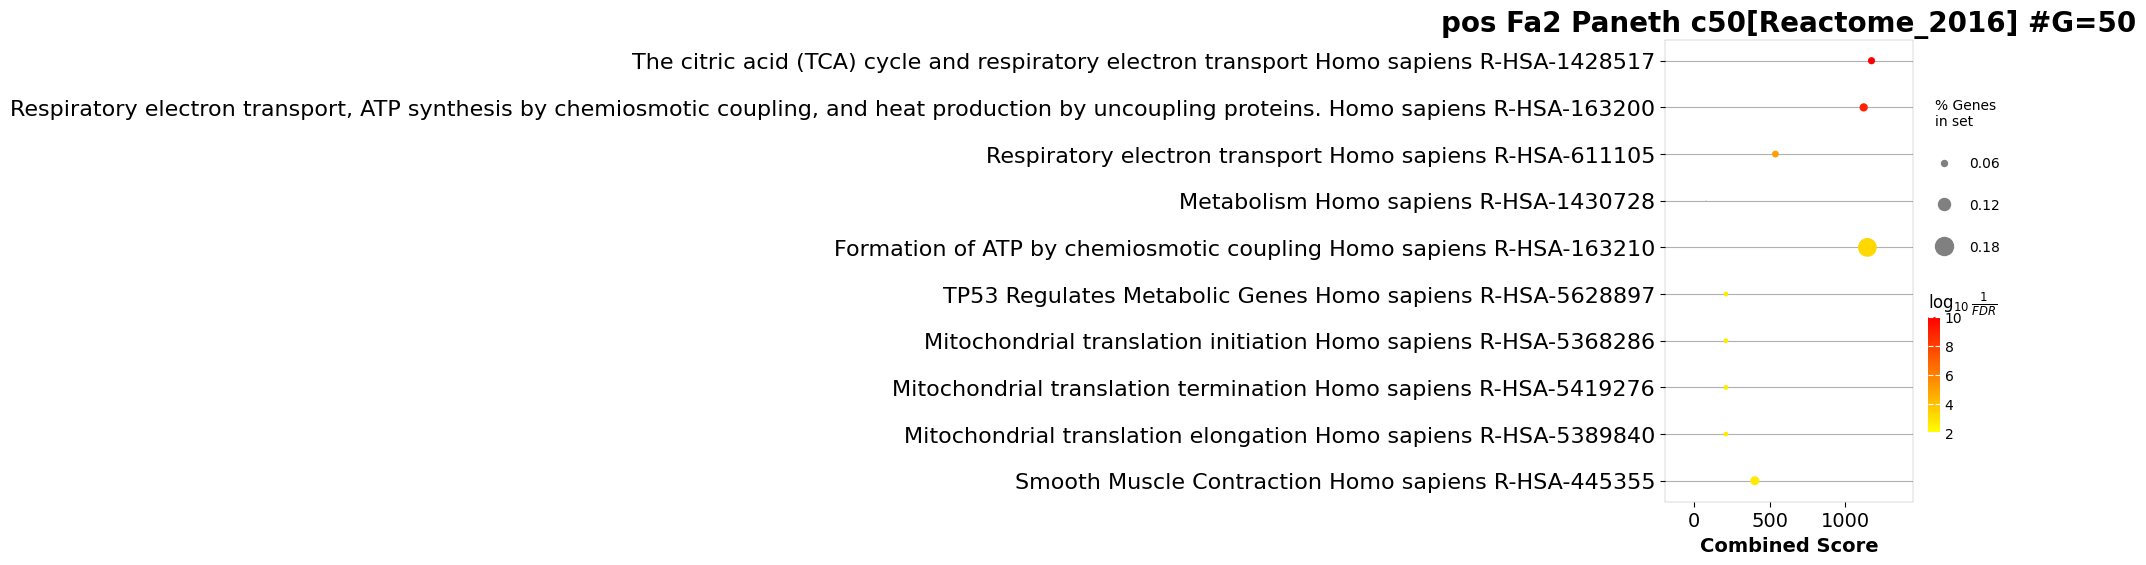

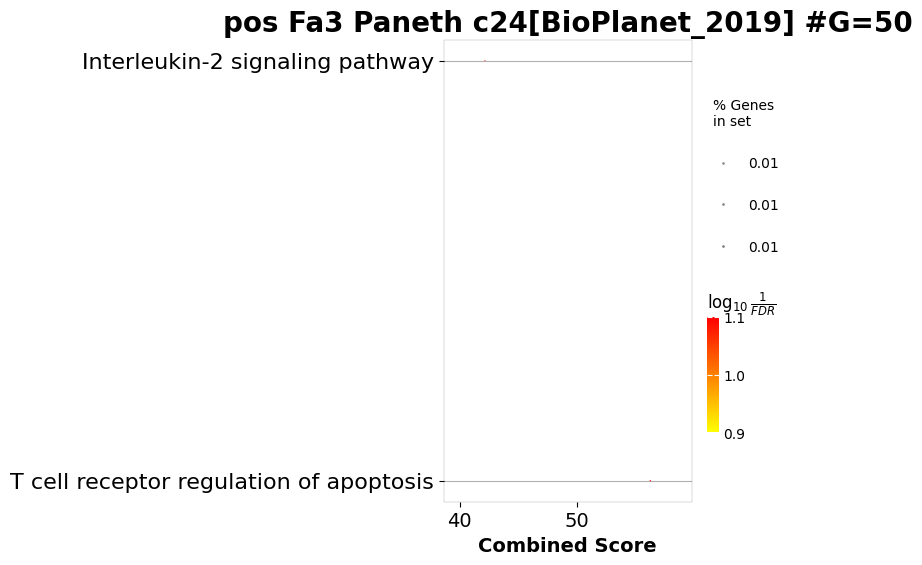

In [36]:
scov.pathway_analysis(all_output_data,choose_celltypes=['Paneth'],
    NOG_pathway=50,choose_factors_id=[],
    positively_correlated=True,savefigure=False,rps_rpl_mt_genes_included=False)


In this example, pathway analysis is performed for top 50 (NOG_pathway=50) genes, 
negatively correlated (positively_correlated=False) 
with factor 2 (choose_factors_id=[2])
of Goblet cells (choose_celltypes=['Goblet'])
testing for enrichment of BioPlanet pathways (database=['BioPlanet_2019']).

If savefigure=True, then the figures will be saved in the respective folder. 

The pathway figures are saved in  ./spatial_ct_ct_interactions/covariations_R0_F3/Pathway_figures/
cell types found  ['Goblet']


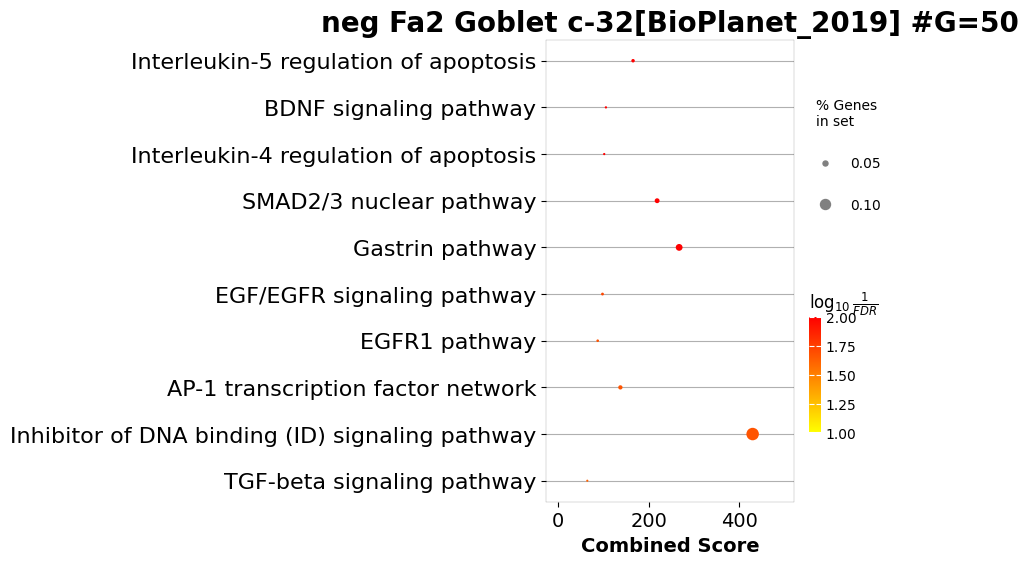

In [37]:
scov.pathway_analysis(all_output_data,choose_celltypes=['Goblet'],NOG_pathway=50,choose_factors_id=[2],
                      positively_correlated=False,savefigure=False,database=['BioPlanet_2019'])

### Save as dotplot 
Show the top 20 positively and negatively correlated genes (top_NOG=20) for all latent factors and
the average expression of these genes on a log scale in a single plot. 
In this example, plots are generated for Paneth cells. 

If the choose_celltypes=[], the plot will be generated for all cell types. 

cell types found  ['Paneth']
The figures are saved:  ./spatial_ct_ct_interactions/covariations_R0_F3/dotplots/Paneth.png


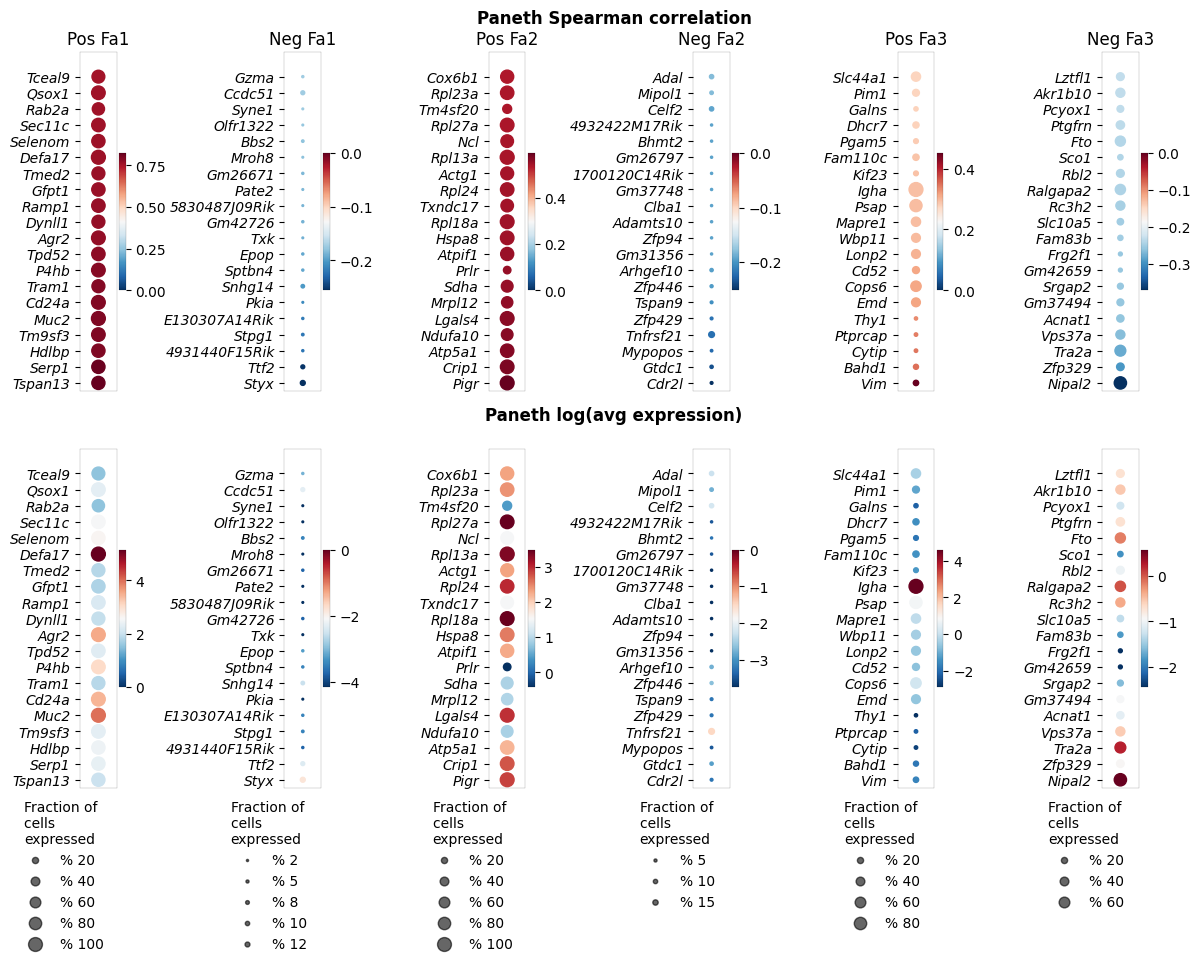

In [38]:
scov.plot_top_selected_genes_for_all_factors_from_chosen_celltype(all_output_data,saveas='png',
                        choose_celltypes=['Paneth'])

cell types found  ['Stem/TA']
The figures are saved:  ./spatial_ct_ct_interactions/covariations_R0_F3/dotplots/Stem_TA.pdf


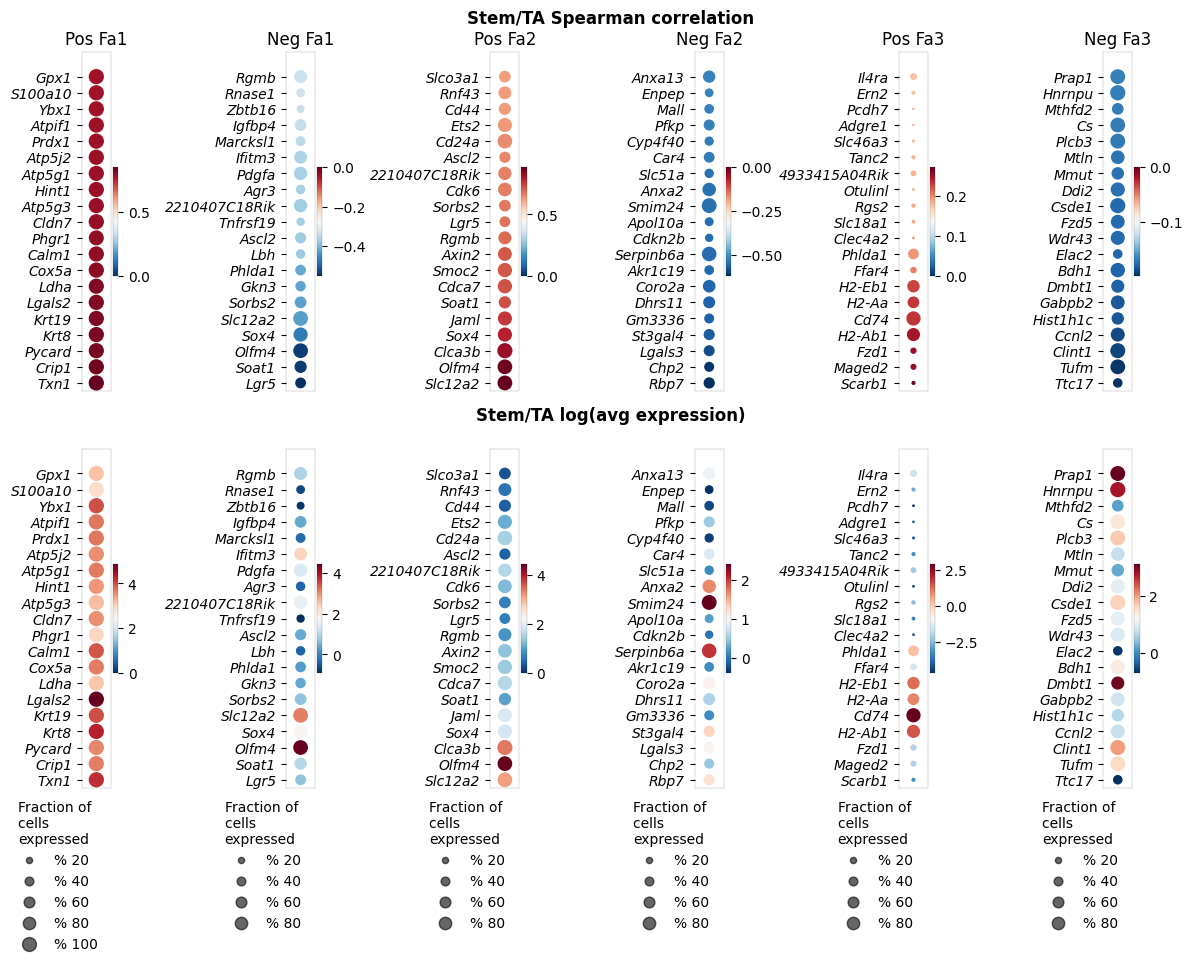

In [39]:
scov.plot_top_selected_genes_for_all_factors_from_chosen_celltype(all_output_data,saveas='pdf',
                        choose_celltypes=['Stem/TA'])

# Visualize factor values in the UMAP

Visualize factor values for select cell types, e.g., Stem/TA and Paneth cells (choose_interacting_celltype_pair=['Stem/TA','Paneth']) in scRNA-seq data umap.
Select factors for each cell type (visualize_factors_id=[1,1]). List entries correspond to cell types in choose_interacting_celltype_pair.


The figures are saved:  ./spatial_ct_ct_interactions/covariations_R0_F3/scRNAseq_factors_in_umap.png


0

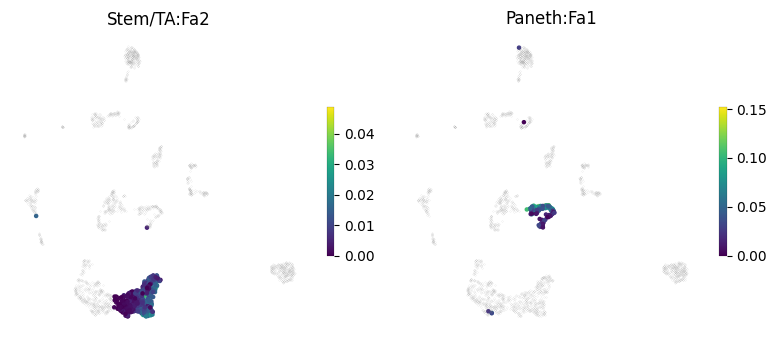

In [41]:
scov.visualize_factors_in_scRNAseq_umap(all_output_data,refpath=ref_datapath,
        choose_interacting_celltype_pair=['Stem/TA','Paneth'],
                                  saveas='png',      
        visualize_factors_id=[2,1])


The figures are saved:  ./spatial_ct_ct_interactions/covariations_R0_F3/spatial_factors_in_umap.png


0

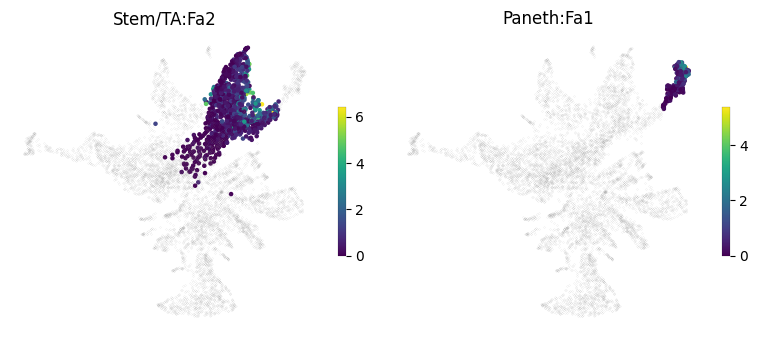

In [42]:
scov.visualize_factors_in_spatial_umap(all_output_data,quepath=query_datapath,
                choose_interacting_celltype_pair=['Stem/TA','Paneth'],
                visualize_factors_id=[2,1],
                saveas='png')
